# Publishing Figures - Single Kappa (free troposphere)
This obtains all figures for a comparison between two simulations of neighbouring optical depth that require the free troposphere as well as surface variables.

In [2]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2023-08-23 16:53:24,846 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [3]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

Also get an equivalent dataset consisting of free troposphere rather than surface values: `ds_all_ft`.

In [4]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [9]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
season = 'all'
# season = 'summer'   # NOTE - if summer, does not give many days corresponding to high percentiles as only 5 years of data used

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(pfull=[np.inf, pressure_ft], method='nearest').sel(time=slice(use_time_start, np.inf))

        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)
p_surface = float(ds_all[0].pfull[0]) * 100
pressure_ft_actual = float(ds_all[0].pfull[-1]) * 100       # Actual pressure of free troposphere (Pa)

100%|██████████| 2/2 [00:19<00:00,  9.63s/it]


In [14]:
ds_all[0].pfull.shape[0]

2

In [24]:
# Get values averaged around a surface temperature percentile, rather than exactly on it.
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
n_lat = ds_all[0].lat.shape[0]
n_pressure = ds_all[0].pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine

temp_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant)) 
temp_median = np.zeros((n_exp, n_pressure, n_lat))
temp_mean = np.zeros((n_exp, n_pressure, n_lat))   
# In free troposphere, this is saturated MSE.
mse_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant))  
mse_mean = np.zeros((n_exp, n_pressure, n_lat))
with tqdm(total=n_exp*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        mse = moist_static_energy(ds_all[i].temp[0], ds_all[i].sphum[0], ds_all[i].height[0])
        mse_ft = moist_static_energy(ds_all[i].temp[-1], sphum_sat(ds_all[i].temp[-1], pressure_ft_actual), ds_all[i].height[-1])
        mse_mean[i, 0] = mse.mean(dim='lon_time')
        mse_mean[i, 1] = mse_ft.mean(dim='lon_time')
        temp_median[i] = ds_all[i].temp.median(dim='lon_time')
        for k in range(n_lat):
            for j, quant in enumerate(quant_plot):
                # Take percentile to be temperature percentile
                use_ind = get_quant_ind(ds_all[i].temp[0, k], quant, 0.5, 0.5)
                temp_quant3[i, :, k, j] = ds_all[i].temp[:, k, use_ind].mean(dim='lon_time')
                mse_quant3[i, 0, k, j] = mse[k, use_ind].mean(dim='lon_time')
                mse_quant3[i, 1, k, j] = mse_ft[k, use_ind].mean(dim='lon_time')
                pbar.update(1)

100%|██████████| 12672/12672 [01:44<00:00, 121.66it/s]


## $\lambda$ Decompostion
### Combine latitudes
Here, I break down the $\lambda=1$ approximation into three different factors. $\lambda_1$ represents CQE on the $x$ percentile day. $\lambda_2$ represents the weak temperature gradient approximation and $\lambda_3$ represents CQE on the mean day.

Note the black line below differs from actual $\lambda$ because here I am plotting it as a function of near-surface temperature percentile, whereas for lambda plot in `surface/single_kappa` notebook, I plot it as a function of near-surface MSE percentile. I.e. the x-axis are different.

In [25]:
lambda_1 = (mse_quant3[1] - mse_quant3[0])[0] / (mse_quant3[1]-mse_quant3[0])[1]
lambda_2 = (mse_quant3[1]-mse_quant3[0])[1] / np.expand_dims(mse_mean[1]-mse_mean[0], axis=-1)[1]
lambda_3 = (mse_mean[1]-mse_mean[0])[0] / (mse_mean[1]-mse_mean[0])[1]
labels = ['$\lambda(x) = \delta h(x)/\delta \overline{h} = \lambda_1(x) \lambda_2(x) \lambda_3^{-1}$',
          '$\lambda_1(x) = \delta h(x) / \delta h_{FT, sat}(x)$',
          '$\lambda_2(x) = \delta h_{FT, sat}(x) / \delta \overline{h}_{FT, sat}$',
          '$\lambda_3 = \delta \overline{h} / \delta \overline{h}_{FT, sat}$']

In [40]:
# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# Global
# region = 'Global'
# lat_min = 0
# lat_max = 90

lat_use = np.where((np.abs(ds_all[0].lat) <= lat_max) & (np.abs(ds_all[0].lat) >= lat_min))[0]
lat_weights_use = lat_weights[lat_use]

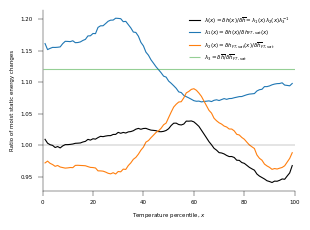

In [41]:
save_lambda_decomp_fig = True
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.spines[['right', 'top']].set_visible(False)
for i, var in enumerate([lambda_1*lambda_2/np.expand_dims(lambda_3, axis=-1), lambda_1, lambda_2]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(quant_plot, np.average(var[lat_use], axis=0, weights=lat_weights_use),
            color=use_color, label=labels[i])
# ax.plot(quant_plot, np.average(lambda_1, axis=0, weights=lat_weights), color=default_colors[0], label=labels[1])
# ax.plot(quant_plot, np.average(lambda_2, axis=0, weights=lat_weights), color=default_colors[1])
ax.hlines(np.average(lambda_3[lat_use], axis=0, weights=lat_weights_use), 0, 100, color=default_colors[2], alpha=0.5, label=labels[3])
ax.hlines(1, 0, 100, color='k', lw=ax_linewidth, alpha=0.5)
ax.legend()
ax.set_xlim(0, 100)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Ratio of moist static energy changes')
plt.tight_layout()
if save_fig or save_lambda_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_{region.lower()}_{season}",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight')

### High percentiles as function of latitude
In the plot below, the quantiles in the order $90, 95, 99$ are represented in terms of lines of increasing opacity i.e. the darkest lines represent $x=99$.

In [42]:
def abs_lat_av(var):
    # averages across indices with the same absolute latitude
    var_av = np.zeros(int(len(var)/2))
    for i in range(len(var_av)):
        var_av[i] = np.mean([var[i], var[-1-i]])
    return var_av[::-1]     # invert order so latitude is increasing

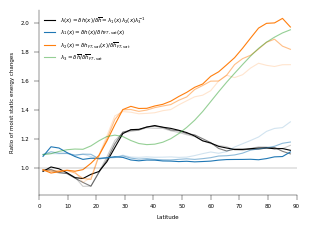

In [48]:
quant_subset = [90,95,99]
quant_subset_ind = numpy_indexed.indices(quant_plot, quant_subset)
lat_plot = ds_all[0].lat[int(n_lat/2):]

save_lambda_decomp_lat_fig = True
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.spines[['right', 'top']].set_visible(False)
for i, var in enumerate([lambda_1*lambda_2/np.expand_dims(lambda_3, axis=-1), lambda_1, lambda_2]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[0]]), alpha=0.2, color=use_color)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[1]]), alpha=0.5, color=use_color)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[2]]), alpha=1, color=use_color, label=labels[i])
ax.plot(lat_plot, abs_lat_av(lambda_3), color=default_colors[2], alpha=0.5, label=labels[3])
ax.hlines(1, -90, 90, color='k', alpha=0.5, lw=ax_linewidth)
ax.set_xlim(0, 90)
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('Ratio of moist static energy changes')
plt.tight_layout()
if (save_fig or save_lambda_decomp_lat_fig):
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_lat_{season}",
                dpi=dpi['combination'] if publish_fig else low_dpi)